# 15-1. 들어가며

## 학습 목표

---

- 딥러닝 문제 구성에 대한 기본적인 이해를 높인다.
- Neural Network에 사용되는 용어들에 대한 이해를 높인다.
- 딥러닝 프레임워크를 사용하지 않고, Numpy만을 이용해 딥러닝 모델과 훈련 과정을 직접 구현해 본다.

# 15-2. 신경망 구성 (1) 개요

신경망(Neural Network)이란 무엇일까요?

우리 뇌에는 1000억 개에 가까운 신경계 뉴런들이 있다고 합니다.
이 뉴런들은 서로 매우 복잡하게 얽혀 있고, 조금 물러서서 보면 하나의 거대한 그물망과 같은 형태를 이루고 있습니다.
보통 우리는 이를 신경망이라고 부릅니다.

예전부터 인류는 자연의 모습을 본떠 인공적인 물건을 만들려는 시도를 많이 해왔습니다.
물론 이것이 자연의 모습을 본뜬 것만이 성공적이라는 뜻은 아니지만요. (새가 나는 방식과 비행기가 나는 방식은 다른 것처럼요.)

머신러닝/딥러닝 과학자들도 자연에서 답을 찾으려 노력했고, 우리 뇌 속의 신경망 구조에 착안해서 퍼셉트론(Perceptron)이라는 형태를 제안하며 이를 연결한 형태를 인공신경망(Artificial Neural Network)이라고 부르기 시작했습니다.

MNIST Revisited
---
아마도 여러분은 AIFFEL 학습 과정 중에 딥러닝 모델 학습을 몇 번 경험해 보셨을 것입니다.
그렇다면 아마도 가장 처음 다루어본 데이터셋은 틀림없이 MNIST라는 숫자 이미지 데이터셋이었을 것입니다.

딥러닝 프레임워크를 이용하면 몇 줄 안되는 코드만으로 MNIST 데이터셋을 99% 이상의 정확도로
분류할 수 있는 이미지 분류기를 만들 수 있으며, 이를 활용해서
다양한 카테고리의 이미지 분류기로 확장해 나갈 수 있다는 것도 이미 알고 계실 것입니다.

그럼 한번 MNIST 이미지 분류기 모델이 어떻게 구성되었는지 기억을 되짚어 볼까요?
아래는 이미 여러 번 구현해 보았던 Tensorflow 기반 분류 모델 예시 코드입니다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

# 모델에 맞게 데이터 가공
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
x_train_reshaped = x_train_norm.reshape(-1, x_train_norm.shape[1]*x_train_norm.shape[2])
x_test_reshaped = x_test_norm.reshape(-1, x_test_norm.shape[1]*x_test_norm.shape[2])

# 딥러닝 모델 구성 - 2 Layer Perceptron
model=keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))  # 입력층 d=784, 은닉층 레이어 H=50
model.add(keras.layers.Dense(10, activation='softmax'))   # 출력층 레이어 K=10
model.summary()

# 모델 구성과 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train_reshaped, y_train, epochs=10)

# 모델 테스트 결과
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8114 - accuracy: 0.8171
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2443 - accuracy: 0.9323
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1863 - accuracy: 0.9479
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1568 - accuracy: 0.9545
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1324 - accuracy: 0.9625
Epoc

이미 여러분은 Conv2D같이 이미지 분류에 특화된 모델을 사용해 본 경험이 있을 것입니다만,
오늘은 그보다 가장 기본적인 신경망 형태인 다층 퍼셉트론(Multi-Layer Perceptron; MLP)만을 이용해서 더욱 간단하게 구현해 보았습니다.
뇌 속의 뉴런이 1000억 개라지만 위에서 만든 모델은 굳이 Conv2D를 사용하지도 않았는데도 39,760개의 파라미터만으로 테스트 성능이 97%에 육박하고 있습니다.
오늘은 인공신경망의 실제 구현 원리를 보다 명확하게 이해하기 위해, 그동안 들춰보지 않았던 프레임워크 내부에서 일어나는 일을 Numpy를 활용해 직접 구현해 보면서 이해해 보고자 합니다.

다층 퍼셉트론 Overview
---
위의 이미지는 총 3개의 레이어로 구성된 퍼셉트론을 나타냅니다. 위에서 보았던 예시 코드와도 동일합니다. 은닉층에는 H개의 노드이, 출력층에는 K개의 노드가 존재하는 인공신경망을 표현한 것입니다. (+1 부분은 bias를 뜻하는 부분이므로 이전 레이어와의 연결이 없습니다. ) 위의 코드에서는 H=50, K=10, 그리고 입력층 노드 개수 d=784로 정의되었습니다.

위의 이미지를 보면 입력값이 있는 입력층(input layer), 최종 출력값이 있는 출력층(output layer), 그리고 그 사이에 있는 층인 은닉층(hidden layer)이 있습니다. 보통 입력층과 출력층 사이에 몇 개의 층이 존재하든 모두 은닉층이라고 부릅니다.

보통 그림으로 인공신경망을 표현할 때에는 노드를 기준으로 레이어를 표시해서 3개의 레이어라고 생각할 수 있지만, 실제로는 총 2개의 레이어를 가졌습니다. 레이어 개수를 셀 때는 노드와 노드 사이의 연결하는 부분이 몇 개 존재하는지 세면 보다 쉽게 알 수 있습니다.

이렇게 인공신경망이 어떻게 생겼는지 대략 알아봤는데요. 인공신경망 중에서도 위의 이미지처럼 2개 이상의 레이어를 쌓아서 만든 것을 보통 다층 퍼셉트론(Multi-Layer Perceptron; MLP)이라고 부릅니다. 그리고 입력층, 출력층을 제외한 은닉층이 많아지면 많아질수록 인공신경망이 DEEP 해졌다고 이야기합니다.

여기서 좀 감이 오시나요? 우리가 지금 알아보려고 하는 딥러닝이 바로 이 인공신경망이 DEEP해졌다는 뜻에서 나온 단어입니다. 그래서 우리가 하려는 딥러닝은 충분히 깊은 인공신경망을 활용하며 이를 보통 다른 단어로 DNN(Deep Neural Network)라고 부릅니다.

💡 Tips
Fully-Connected Neural Network와 같은 단어를 들어보신 분들이 있으신가요? 이는 앞에서 설명드렸던 MLP의 다른 용어입니다. 이 Fully-Connnected Nerual Network는 서로 다른 층에 위치한 노드 간에는 연결 관계가 존재하지 않으며, 인접한 층에 위치한 노드들 간의 연결만 존재한다는 의미를 내포합니다.

Parameters/Weights
---
앞에서 설명한 입력층-은닉층, 은닉층-출력층 사이에는 사실 각각 행렬(Matrix)이 존재합니다. 여러분 모두 고등학교 때 배우셨던 행렬 곱셈 기억나시겠죠?

예를 들어 입력값이 100개, 은닉 노드가 20개라면 사실 이 입력층-은닉층 사이에는 100x20의 형태를 가진 행렬이 존재합니다. 똑같이, MNIST 데이터처럼 10개의 클래스를 맞추는 문제를 풀기 위해 출력층이 10개의 노드를 가진다면 은닉층-출력층 사이에는 20x10의 형태를 가진 행렬이 존재하게 됩니다.

이 행렬들을 Parameter 혹은 Weight라고 부릅니다. 두 단어는 보통 같은 뜻으로 사용되지만, 실제로 Parameter에는 위의 참고 자료에서 다룬 bias 노드도 포함된다는 점만 유의해 주세요.

이때 인접한 레이어 사이에는 아래와 같은 관계가 성립합니다.

y=W⋅X+b
우리가 위에서 간단히 만들어 보았던 MLP 기반 딥러닝 모델을 Numpy로 다시 만들어 본다고 생각해 봅시다.

In [2]:
# 입력층 데이터의 모양(shape)
print(x_train_reshaped.shape)

# 테스트를 위해 x_train_reshaped 의 알 5개의 데이터를 가져온다.
X = x_train_reshaped[:5]
print(X.shape)

(60000, 784)
(5, 784)


In [3]:
weight_init_std = 0.1
input_size = 784
hidden_size=50

# 인접 레이어간 관계를 나타내는 파라미터 W를 생성하고 random 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)  
# 바이어스 파라미터 b를 생성하고 Zero로 초기화
b1 = np.zeros(hidden_size)

a1 = np.dot(X, W1) + b1   # 은닉층 출력

print(W1.shape)
print(b1.shape)
print(a1.shape)

(784, 50)
(50,)
(5, 50)


In [4]:
# 첫 번째 데이터의 은닉층 출력을 확인해 봅시다.  50dim의 벡터가 나오나요?
a1[0]

array([-9.17901513e-04, -4.52699356e-02, -2.95871509e-01, -4.53762181e-01,
       -4.82011960e-01,  8.64558099e-01,  2.61235009e+00, -5.11117771e-01,
        6.44833934e-01,  4.17147912e-02, -1.17496331e-01,  7.12236888e-01,
       -9.53228336e-01,  3.13564944e-02,  6.49298056e-01, -1.52467197e-01,
        4.24391733e-01, -1.88107561e+00, -1.64095142e+00,  3.17532275e-01,
       -2.62761625e-01, -1.06043547e-02,  5.72190408e-01, -9.74457870e-01,
        1.10781604e+00,  1.65148431e+00,  1.04122996e-01,  7.02509955e-01,
        1.79305062e-01,  4.93817408e-01,  1.59251498e-01, -1.69239060e+00,
       -9.46619226e-03,  1.47023930e+00,  4.40621611e-01,  3.43771212e-01,
       -4.30024400e-01,  2.09429416e-01,  6.95685851e-01, -9.54110933e-01,
        5.69381041e-01,  7.15654201e-01,  5.77802216e-01,  8.52887603e-01,
        8.94217140e-01,  4.50902122e-01, -2.22645829e-01,  1.30888992e+00,
        1.13811530e+00,  1.72109496e+00])

# 15-3. 신경망 구성 (2) 활성화 함수와 손실 함수

활성화 함수 (Activation Functions)
---

MLP의 또 다른 중요한 구성요소는 바로 활성화 함수인데요.

딥러닝에서는 이 활성화 함수의 존재가 필수적입니다.

수학적인 이유가 있지만, 간단히만 설명하자면 이 활성화 함수는 보통 비선형 함수를 사용하는데

이 비선형 함수를 MLP 안에 포함시키면서 모델의 표현력이 좋아지게 됩니다.

(정확히는 레이어 사이에 이 비선형 함수가 포함되지 않은 MLP는 한 개의 레이어로 이루어진 모델과 수학적으로 다른 점이 없습니다.)

### 1. Sigmoid

σ(x)=1/(1+e^−x)

이전 스텝에서 우리는 은닉층의 출력에다 활성화 함수로 sigmoid를 사용한 바 있습니다.

model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))

그럼 첫 번째 은닉층의 출력 a1에다가 sigmoid를 적용해 봅시다.

In [5]:
# 위 수식의 sigmoid 함수를 구현해 봅니다.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

z1 = sigmoid(a1)
print(z1[0])  # sigmoid의 출력은 모든 element가 0에서 1사이

[0.49977052 0.48868445 0.42656704 0.38846665 0.38177714 0.70361209
 0.93165219 0.37493153 0.65584536 0.51042719 0.47065966 0.67089524
 0.27823604 0.50783848 0.65685226 0.46195687 0.60453367 0.13226538
 0.16233564 0.57872273 0.43468496 0.49734894 0.63926845 0.27399285
 0.75172173 0.83909156 0.52600726 0.66874403 0.54470655 0.6210053
 0.53972895 0.15546171 0.49763347 0.81309376 0.60840714 0.5851063
 0.3941205  0.55216682 0.66723058 0.27805883 0.63862034 0.67164933
 0.64056154 0.70117253 0.70975967 0.6108537  0.44456734 0.78732734
 0.75733344 0.84826982]


예전부터 활성화 함수로 많이 써오던 sigmoid 함수입니다.

현재는 아래에서 설명할 ReLU 함수를 더 많이 사용하는데 그 이유는 다음과 같습니다.

- vanishing gradient 현상이 발생한다.
- exp 함수 사용 시 비용이 크다.

아래 참고 자료는 아래 섹션인 오차역전파법(BackPropagation)을 공부하신 다음 보시면 더욱 이해하기 편할 수 있습니다.

### 2. Tanh
tanh(x) =(e^x−e^−x) / (e^x + e^−x)

- tanh 함수는 함수의 중심값을 0으로 옮겨 sigmoid의 최적화 과정이 느려지는 문제를 해결.
- vanishing gradient 문제 존재.

### 3. ReLU

f(x)=max(0,x)

- sigmoid, tanh 함수에 비해 학습이 빠름.
- 연산 비용이 크지 않고, 구현이 매우 간단하다.

In [8]:
# 단일 레이어 구현 함수
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

print('go~')

go~


In [9]:
input_size = 784
hidden_size = 50
output_size = 10

W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)    # z1이 다시 두번째 레이어의 입력이 됩니다. 

print(a2[0])  # 최종 출력이 output_size만큼의 벡터가 되었습니다.

[-0.23177177  0.09154804  0.6153682   0.3615112  -0.48588492  0.67354776
  0.16215521  0.14277771  0.48480508  0.02321346]


In [10]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [11]:
y_hat = softmax(a2)
y_hat[0]  # 10개의 숫자 중 하나일 확률이 되었습니다.

array([0.06231344, 0.08609893, 0.14537507, 0.11278238, 0.04833056,
       0.15408381, 0.09239789, 0.09062468, 0.12758132, 0.08041192])

손실함수 (Loss Functions)
---

이렇게 비선형 활성화 함수를 가진 여러 개의 은닉층을 거친 다음 신호 정보들은 출력층으로 전달됩니다. 이때 우리가 원하는 정답과 전달된 신호 정보들 사이의 차이를 계산하고, 이 차이를 줄이기 위해 각 파라미터들을 조정하는 것이 딥러닝의 전체적인 학습 흐름입니다.

이 차이를 구하는 데 사용되는 함수는 손실함수(Loss function) 또는 비용함수(Cost function)라고 부릅니다. 대표적으로 다음과 같은 두 가지 손실함수가 존재합니다.

교차 엔트로피 (Cross Entropy)
---
오늘 우리는 바로 Cross Entropy를 이용해 모델을 학습할 것입니다.

Cross Entropy는 두 확률분포 사이의 유사도가 클수록 작아지는 값입니다. 아직 별로 학습되지 않은 현재의 모델이 출력하는 softmax 값 
ˆ 은 10개의 숫자 각각의 확률이 대부분 0.1 근처를 오가는 정도입니다.

모델을 학습하게 되면, ˆ 이 점점 정답에 가까워지게 됩니다. 정말 그렇게 되는지 다음 스텝에서 살펴봅시다.

우선은 ˆ과 정답을 비교해 봅시다.

In [12]:
# 정답 라벨을 One-hot 인코딩하는 함수
def _change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

Y_digit = y_train[:5]
t = _change_one_hot_label(Y_digit, 10)
t     # 정답 라벨의 One-hot 인코딩

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [13]:
print(y_hat[0])
print(t[0])

[0.06231344 0.08609893 0.14537507 0.11278238 0.04833056 0.15408381
 0.09239789 0.09062468 0.12758132 0.08041192]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [14]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

Loss = cross_entropy_error(y_hat, t)
Loss

2.601999191092317

# 15-4. 경사하강법

그럼 이제 오차는 구했습니다. 다음 단계는 무엇일까요?

앞서 말씀드렸지만 우리는 이 오차를 줄이는 것이 목표입니다. 이 상황은 우리가 마치 산꼭대기에 서 있는 것과 동일하게 생각할 수 있습니다.

우리는 얼른 이 산에서 내려가서 집에 가고 싶은 사람들이죠. 여러분들이라면 어디로 내려가야 할지 모를 때 어떻게 하시겠어요?

아마도 내리막길을 따라 일단 내려가 보지 않을까요?

경사하강법(Gradient Descent) 또한 동일한 원리입니다. 각 단계에서의 기울기를 구해서 해당 기울기가 가리키는 방향으로 이동하는 방법이죠.

위의 이미지처럼 각 시점의 기울기가 가리키는 방향으로 이동해나가는 것이죠.

그럼 경사하강법을 사용하면 항상 산 아래에 잘 도착할 수 있을까요?

예를 들어, 우리가 너무 크게 발걸음을 내딛을 수 있는 거인이라면 아마도 산 아래로 내려가지 못하고 또 다른 골짜기에 빠지고 말 것입니다. 

또한, 이미 생각해 보신 분들도 있겠지만,

아무리 우리가 발걸음을 잘 내디딘다고 해도 어디서 출발했느냐에 따라

산 아래로 내려가는 시간이 빨라질 수도 느려질 수도 있습니다.

이는 parameter의 값들을 어떻게 초기화하는지의 문제와 맞닿아 있으니, 아래의 참고 자료를 확인해주세요.

X-Y 좌표축의 기울기란 X의 변화에 따른 Y의 변화량을 의미합니다. Y를 X로 미분해서 구하지요.

우리는 파라미터 W의 변화에 따른 오차(Loss) L의 변화량을 구하려고 합니다.

그러면 오차 기울기가 커지는 방향의 반대 방향으로 파라미터를 조정해 주면 됩니다.

단, 조정을 너무 많이 해주면 안 되기 때문에 적절한 step size 역할을 하는 learning rate가 필수적입니다.

그 과정을 Numpy를 통해 구현해 보겠습니다.

In [15]:
batch_num = y_hat.shape[0]
dy = (y_hat - t) / batch_num
dy    # softmax값의 출력으로 Loss를 미분한 값

array([[ 0.01246269,  0.01721979,  0.02907501,  0.02255648,  0.00966611,
        -0.16918324,  0.01847958,  0.01812494,  0.02551626,  0.01608238],
       [-0.18712227,  0.0185282 ,  0.03109982,  0.0236723 ,  0.01083907,
         0.03180446,  0.01972896,  0.01778314,  0.02169136,  0.01197495],
       [ 0.01628565,  0.02157513,  0.02668964,  0.02456397, -0.19038879,
         0.02838714,  0.01595393,  0.01770457,  0.02299893,  0.01622984],
       [ 0.01552675, -0.18531629,  0.0313917 ,  0.0282854 ,  0.00907748,
         0.02678402,  0.0147113 ,  0.02180615,  0.0229661 ,  0.01476739],
       [ 0.01491965,  0.0177593 ,  0.02918287,  0.0250114 ,  0.01023266,
         0.03076371,  0.0169318 ,  0.02021309,  0.02219934, -0.18721382]])

In [16]:
dW2 = np.dot(z1.T, dy)    
dW2

array([[-0.0929675 , -0.03951976,  0.08594537,  0.07212224, -0.07742935,
        -0.00264449,  0.05036208,  0.05570108,  0.06659457, -0.11816424],
       [-0.10603116, -0.05011894,  0.0845461 ,  0.07047045, -0.07400747,
        -0.03044122,  0.04968546,  0.05426786,  0.06575826, -0.06412934],
       [-0.00917854, -0.07123295,  0.05771724,  0.04953122, -0.08546645,
        -0.02587822,  0.03286049,  0.03804466,  0.04586996, -0.03226741],
       [-0.02158413, -0.09040899,  0.07200594,  0.06257137, -0.13444672,
         0.02597514,  0.04064266,  0.0477352 ,  0.05649125, -0.05898171],
       [-0.04615216, -0.06808135,  0.06141626,  0.05122219, -0.04313373,
        -0.06967572,  0.03564391,  0.0395894 ,  0.04858088, -0.00940968],
       [-0.04670341, -0.0569579 ,  0.06048738,  0.05091563, -0.04942453,
        -0.02589684,  0.03496331,  0.03935229,  0.04724666, -0.05398259],
       [-0.07628539, -0.0170418 ,  0.05980649,  0.05007033, -0.08650724,
        -0.0145595 ,  0.03549057,  0.03827854

In [17]:
dW2 = np.dot(z1.T, dy)
db2 = np.sum(dy, axis=0)

In [18]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [19]:
dz1 = np.dot(dy, W2.T)
da1 = sigmoid_grad(a1) * dz1
dW1 = np.dot(X.T, da1)
db1 = np.sum(dz1, axis=0)

In [20]:
# 파라미터를 업데이트하는 함수를 생각해 봅시다. learning_rate도 고려해야 합니다.

learning_rate = 0.1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    return W1, b1, W2, b2

# 15-5. 오차역전파법이란?

이제 우리는 손실 함수를 통해 구해진 오차를 가지고 각 파라미터들을 조정하는 경사하강법에 대해 알게 되었습니다.
그럼 이 기울기를 어떻게 입력층까지 전달하며 파라미터들을 조정해 나갈 수 있을까요?
이 과정에서 쓰이는 개념이 오차역전파법(Backpropagation) 입니다.

오차역전파법은 앞에서 설명한 MLP를 학습시키기 위한 일반적인 알고리즘 중 하나입니다.
이는 출력층의 결과와 내가 뽑고자 하는 target 값과의 차이를 구한 뒤,
그 오차 값을 각 레이어들을 지나며 역전파 해가며 각 노드가 가지고 있는 변수들을 갱신해 나가는 방식입니다.

In [21]:
def affine_layer_backward(dy, cache):
    X, W, b = cache
    dX = np.dot(dy, W.T)
    dW = np.dot(X.T, dy)
    db = np.sum(dy, axis=0)
    return dX, dW, db

In [22]:
# 파라미터 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

# Forward Propagation
a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)

# 추론과 오차(Loss) 계산
y_hat = softmax(a2)
t = _change_one_hot_label(Y_digit, 10)   # 정답 One-hot 인코딩
Loss = cross_entropy_error(y_hat, t)

print(y_hat)
print(t)
print('Loss: ', Loss)
        
dy = (y_hat - t) / X.shape[0]
dz1, dW2, db2 = affine_layer_backward(dy, cache2)
da1 = sigmoid_grad(a1) * dz1
dX, dW1, db1 = affine_layer_backward(da1, cache1)

# 경사하강법을 통한 파라미터 업데이트    
learning_rate = 0.1
W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

[[0.07246494 0.12004428 0.08770718 0.04257361 0.11161916 0.126041
  0.1137354  0.10937236 0.0498207  0.16662138]
 [0.07086715 0.10669314 0.09749037 0.04600193 0.10587795 0.14316574
  0.11453214 0.09351482 0.05755656 0.16430021]
 [0.10014421 0.10256104 0.08095751 0.03723466 0.12600765 0.15067429
  0.11218652 0.0934174  0.05627014 0.14054658]
 [0.08526375 0.10697223 0.09826323 0.04765958 0.09995751 0.14882398
  0.10453098 0.09611919 0.05911729 0.15329225]
 [0.07615192 0.12911812 0.0815203  0.03663428 0.12360692 0.14895602
  0.10019515 0.09337859 0.06406359 0.1463751 ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.1892555495572745


# 15-6. 모델 학습 Step-by-Step

방금 우리는 한 스텝의 Forward Propagation과 Backward Propagation을 통해
학습해야 할 파라미터 W1, b1, W2, b2가 업데이트되는 과정을 확인했습니다.

과연 이렇게 파라미터가 업데이트될 때, 우리의 모델은 점점 더 정확한 추론을 하게 되는 것일까요?

업데이트되는 과정을 다섯 스텝만 반복해 보면서 그 효과를 확인해 보도록 하겠습니다.

In [23]:
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
    a1, cache1 = affine_layer_forward(X, W1, b1)
    z1 = sigmoid(a1)
    a2, cache2 = affine_layer_forward(z1, W2, b2)
    y_hat = softmax(a2)
    t = _change_one_hot_label(Y, 10)
    Loss = cross_entropy_error(y_hat, t)

    if verbose:
        print('---------')
        print(y_hat)
        print(t)
        print('Loss: ', Loss)
        
    dy = (y_hat - t) / X.shape[0]
    dz1, dW2, db2 = affine_layer_backward(dy, cache2)
    da1 = sigmoid_grad(a1) * dz1
    dX, dW1, db1 = affine_layer_backward(da1, cache1)
    
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    return W1, b1, W2, b2, Loss

In [24]:
X = x_train_reshaped[:5]
Y = y_train[:5]

# train_step을 다섯 번 반복 돌립니다.
for i in range(5):
    W1, b1, W2, b2, _ = train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=True)

---------
[[0.0846924  0.08533532 0.11513791 0.09356194 0.09681287 0.20079756
  0.07018293 0.08158424 0.07120184 0.10069299]
 [0.08406563 0.08311891 0.12384193 0.12453734 0.10431409 0.18133194
  0.07562503 0.07289064 0.07506469 0.07520979]
 [0.08493469 0.08751237 0.13286129 0.09183562 0.0922762  0.18406059
  0.06775557 0.08355943 0.08455264 0.0906516 ]
 [0.09117419 0.07868634 0.10922759 0.10864437 0.09219516 0.17450047
  0.09891504 0.08113096 0.07031011 0.09521575]
 [0.08259043 0.06570087 0.12243386 0.10695561 0.08601844 0.18209482
  0.08403936 0.07815568 0.0873768  0.10463413]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.252831150142609
---------
[[0.09936978 0.09790954 0.09459163 0.0794705  0.11091956 0.20971361
  0.06135185 0.07171446 0.06253333 0.11242574]
 [0.10556249 0.09781665 0.1031237  0.1061588  0.12085623 0.18431969
  0.06643276 0.06418047 0.0664

모델이 추론한 확률값 y_hat이 정답의 One-hot 인코딩 t값에 조금씩 근접하는 것과, Loss가 점점 감소하는 것이 확인 할 수 있습니다.

그렇다면 우리는 경사하강법을 통해 조금씩 파라미터를 제대로 업데이트해 가고 있다고 볼 수 있겠습니다.

이제 거의 근접했습니다. 몇 가지만 보완하면 우리는 모델 훈련 전과정을 완성할 수 있겠습니다.

# 15-7. 추론 과정 구현과 정확도(Accuracy) 계산

In [25]:
def predict(W1, b1, W2, b2, X):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

In [26]:
# X = x_train[:100] 에 대해 모델 추론을 시도합니다. 
X = x_train_reshaped[:100]
Y = y_test[:100]
result = predict(W1, b1, W2, b2, X)
result[0]

array([0.14207857, 0.13127779, 0.04980096, 0.04553359, 0.14474284,
       0.22837847, 0.03730645, 0.04353041, 0.0383624 , 0.13898851])

In [27]:
def accuracy(W1, b1, W2, b2, x, y):
    y_hat = predict(W1, b1, W2, b2, x)
    y_hat = np.argmax(y_hat, axis=1)

    accuracy = np.sum(y_hat == y) / float(x.shape[0])
    return accuracy

In [28]:
acc = accuracy(W1, b1, W2, b2, X, Y)

t = _change_one_hot_label(Y, 10)
print(result[0])
print(t[0])
print(acc)

[0.14207857 0.13127779 0.04980096 0.04553359 0.14474284 0.22837847
 0.03730645 0.04353041 0.0383624  0.13898851]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.07


# 15-8. 전체 학습 사이클 수행

In [29]:
# 학습시킬 파라미터를 초기화하는 함수

def init_params(input_size, hidden_size, output_size, weight_init_std=0.01):

    W1 = weight_init_std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = weight_init_std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)

    print(W1.shape)
    print(b1.shape)
    print(W2.shape)
    print(b2.shape)
    
    return W1, b1, W2, b2

In [30]:
# 학습 진행

# 하이퍼파라미터
iters_num = 50000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

W1, b1, W2, b2 = init_params(784, 50, 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train_reshaped[batch_mask]
    y_batch = y_train[batch_mask]
    
    W1, b1, W2, b2, Loss = train_step(x_batch, y_batch, W1, b1, W2, b2, learning_rate=0.1, verbose=False)

    # 학습 경과 기록
    train_loss_list.append(Loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        print('Loss: ', Loss)
        train_acc = accuracy(W1, b1, W2, b2, x_train_reshaped, y_train)
        test_acc = accuracy(W1, b1, W2, b2, x_test_reshaped, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

(784, 50)
(50,)
(50, 10)
(10,)
Loss:  2.3001354852651215
train acc, test acc | 0.09915, 0.1009
Loss:  0.946587491930769
train acc, test acc | 0.7937666666666666, 0.7986
Loss:  0.3771461619708277
train acc, test acc | 0.8759666666666667, 0.8792
Loss:  0.4106922826309253
train acc, test acc | 0.8973, 0.899
Loss:  0.2039646529435182
train acc, test acc | 0.9073166666666667, 0.9083
Loss:  0.28741899473476507
train acc, test acc | 0.9142333333333333, 0.916
Loss:  0.26575039579517584
train acc, test acc | 0.9196166666666666, 0.9225
Loss:  0.2697154930168447
train acc, test acc | 0.9236, 0.9266
Loss:  0.2268982624952903
train acc, test acc | 0.9270333333333334, 0.9283
Loss:  0.19364458061070117
train acc, test acc | 0.9316333333333333, 0.9327
Loss:  0.3146160891237993
train acc, test acc | 0.9341, 0.9343
Loss:  0.34017498890883063
train acc, test acc | 0.9365, 0.9369
Loss:  0.23582162037984158
train acc, test acc | 0.9394333333333333, 0.9382
Loss:  0.1752358888570047
train acc, test acc | 0.9

딥러닝 프레임워크가 없이도 Numpy만으로도 딥러닝이 가능하다는 것을 확인했습니다.

물론 아쉽게도 Numpy는 GPU를 지원하지 않으므로, 방금의 딥러닝은 CPU만 사용한 것입니다.

하지만 이로써 우리는 딥러닝 프레임워크 안에서 일어나는 일의 대강에 대해서 추론해 볼 수 있게 되었습니다.

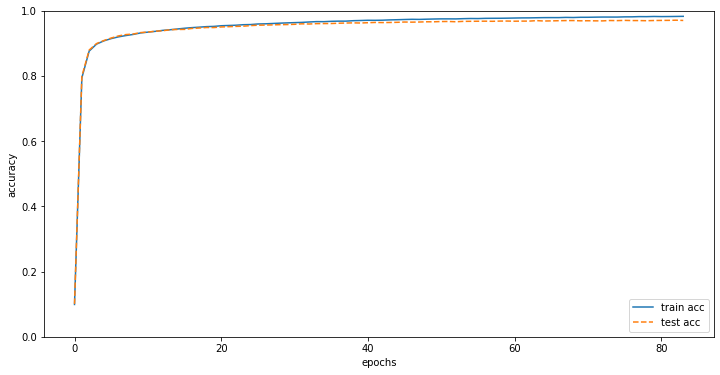

In [31]:
# 위 훈련 과정의 Accuracy, Loss 변화를 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6 

# Accuracy 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

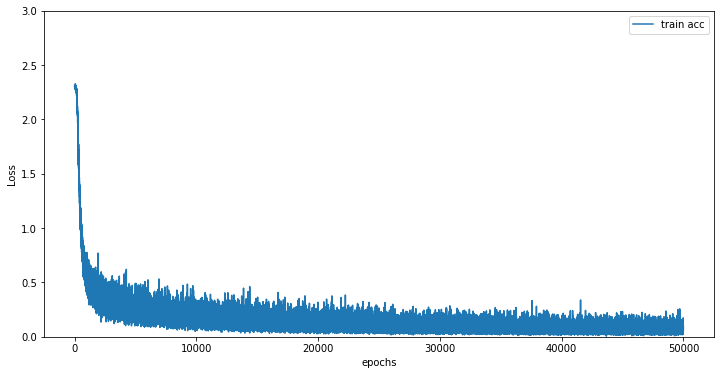

In [32]:
# Loss 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 3.0)
plt.legend(loc='best')
plt.show()

지금까지 그동안 막연히 개념적으로만 이해해 왔던,

텐서플로우 같은 딥러닝 프레임워크에서 자동으로 수행되기 때문에 구체적인 동작 메커니즘이

잘 와닿지 않았던 딥러닝이라는 것을 좀 더 세부적으로 들여다보았습니다.

경사하강법과 오차역전파법을 통해 파라미터가 어떻게 최적화되는지를 이해하는데

오늘의 내용이 도움이 되었기를 바랍니다. 수고하셨습니다!!